# Precipitation Plots: Regridded CMIP6 Models

Plot the CMIP6 models from their regridded NetCDf Files. 

##### Reference

Ben Farris (n.d.) Tutorial: Loading CMIP historical data, https://phaustin.github.io/climate_students_eoas/resources/tutorials/historical_data.html#tut-historical-data

Reference used for code loading data in this notebook.

In [1]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import nc_time_axis
import intake
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from pathlib import Path

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6

## Load Functions

In [2]:
# Function used to load data from google cloud storage
def load_data(dataframe):
    # get the path to a specific zarr store (the first one from the dataframe)
    zstore = dataframe.zstore.values[-1]
    print(zstore)

    # create a mutable-mapping-style interface to the store
    mapper = fsspec.get_mapper(zstore)

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    return ds

# create a function to create an Xarray data array for historical simulations
def data_array(dataset):
    # Create Xarray Data Array
    da = dataset['pr']

    # Collect data for Canada (time period between 1950 and 2010)
    da = da.sel(lon = slice(225, 310), lat = slice(0, 55), time = slice('1950', '2010'))
    return da

# Create data array for future scenario simulations
def data_array_ssp(dataset):
    # Create Xarray Data Array
    da = dataset['pr']

    # Collect data for Canada (time period between 1950 and 2010)
    da = da.sel(lon = slice(225, 310), lat = slice(0, 55), time = slice('2015', '2100'))
    return da

def convert_lon(da):
    # Re-grid longitude to [-180, 180]
    da_180 = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
    return da_180

def convert_precip(da):
    # Convert precipitation units from kg m-2 s-1 to mm yr-1
    da_yr = da * (86400*365)
    da_yr = da_yr.assign_attrs(da_yr.attrs)
    da_yr.attrs['units'] = 'mm year-1'
    return da_yr

### Import the CMIP6 Google Cloud Storage

In [3]:
# Import dataset
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cmipdf = col.df

In [4]:
# Folder Directory
home_dir = Path.home()
out_folder = home_dir / "repos/atsc448/data" 

### Open the NetCDf Files

Use Xarrays `out_dataset` to load the files.

In [5]:
can = xr.open_dataset(out_folder / "can_regrid.nc")
gfdl = xr.open_dataset(out_folder / "gfdl_regrid.nc")
had = xr.open_dataset(out_folder / "had_regrid.nc")
nor = xr.open_dataset(out_folder / "nor_regrid.nc")

cmcc_pr = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'pr' & experiment_id == 'historical' & source_id == 'CMCC-CM2-SR5'")


### Selecting and Filtering Data

In [6]:
can_sel = can.sel(member_id='r6i1p2f1', lon = slice(225, 310), lat = slice(0, 55), time = slice('1950', '2010'))
can_ds = can_sel.drop_vars(['member_id', 'dcpp_init_year'])
can_pr = can_ds['pr']

gfdl_sel = gfdl.sel(member_id='r1i1p1f1', lon = slice(225, 310), lat = slice(0, 55), time = slice('1950', '2010'))
gfdl_ds = gfdl_sel.drop_vars(['member_id', 'dcpp_init_year'])
gfdl_pr = gfdl_ds['pr']

had_sel = had.sel(member_id='r5i1p1f3', lon = slice(225, 310), lat = slice(0, 55), time = slice('1950', '2010'))
had_ds = had_sel.drop_vars(['member_id', 'dcpp_init_year'])
had_pr = had_ds['pr']

nor_sel = nor.sel(member_id='r3i1p1f1', lon = slice(225, 310), lat = slice(0, 55), time = slice('1950', '2010'))
nor_ds = nor_sel.drop_vars(['member_id', 'dcpp_init_year'])
nor_pr = nor_ds['pr']

cmcc_ds = load_data(cmcc_pr)
cmcc_pr = data_array(cmcc_ds)

gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/historical/r2i1p2f1/Amon/pr/gn/v20211109/


#### Unit Conversion

Convert the longitude from [0, 360] to [-180, 180] and convert the precipitation units from kg m-2 s-1 to mm year-1.

In [7]:
# Unit and Longitude conversion
can_lon = convert_lon(can_pr)
can_pr = convert_precip(can_lon)

cmcc_lon = convert_lon(cmcc_pr)
cmcc_pr = convert_precip(cmcc_lon)

gfdl_lon = convert_lon(gfdl_pr)
gfdl_pr = convert_precip(gfdl_lon)

had_lon = convert_lon(had_pr)
had_pr = convert_precip(had_lon)

nor_lon = convert_lon(nor_pr)
nor_pr = convert_precip(nor_lon)

In [8]:
# Mean data over time to get average
can_hist = can_pr.mean(dim='time')
cmcc_hist = cmcc_pr.mean(dim='time')
gfdl_hist = gfdl_pr.mean(dim='time')
had_hist = had_pr.mean(dim='time')
nor_hist = nor_pr.mean(dim='time')

### Plot historical data

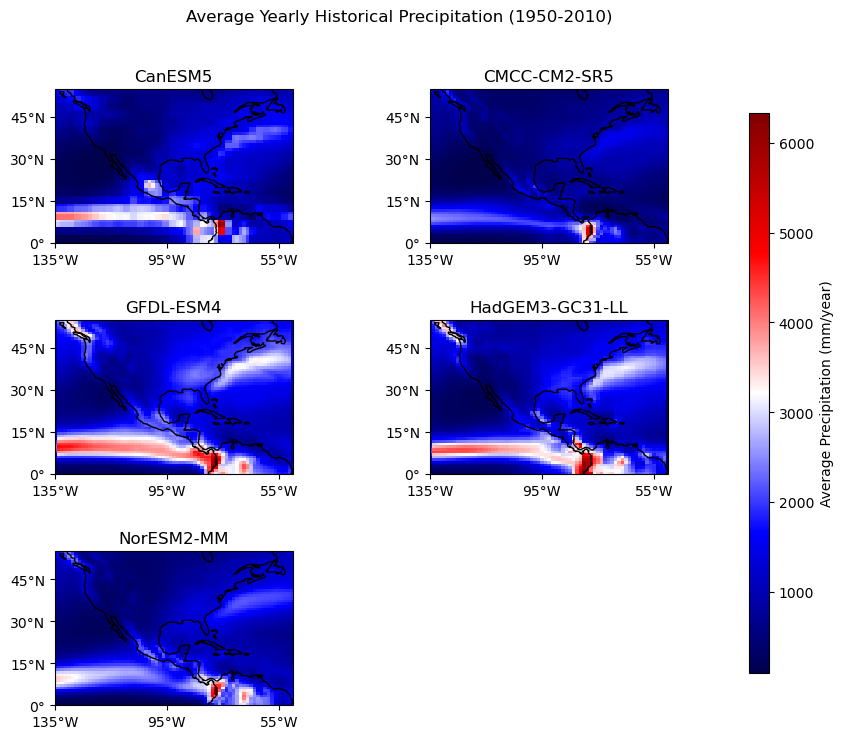

In [9]:
nrows = 3
ncols = 2

models = [can_hist, cmcc_hist, gfdl_hist, had_hist, nor_hist]
names = ['CanESM5', 'CMCC-CM2-SR5', 'GFDL-ESM4', 'HadGEM3-GC31-LL', 'NorESM2-MM']

# Set up figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

#Loop over all of the models
for i,m in enumerate(models):
    cs = m.plot(ax=axs[i], transform=ccrs.PlateCarree(), cmap='seismic',add_colorbar=False)
    
    # Title each subplot with the name of the model
    axs[i].set_title(names[i])
    
    # Draw the coastines for each subplot
    axs[i].coastlines()

    # Set extent for maps
    axs[i].set_extent([-135, -50, 55, 0], crs=ccrs.PlateCarree())

    #Set Longitude Label
    axs[i].set_xticks(np.arange(-135,-50,40), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].xaxis.label.set_visible(False)

    #Set Latitude Label
    axs[i].set_yticks(np.arange(0,55,15), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].yaxis.label.set_visible(False)

# remove extra subplot
fig.delaxes(axs[5])

# set plot title
plt.suptitle("Average Yearly Historical Precipitation (1950-2010)")

#Set colourbar
fig.subplots_adjust(right=0.8, wspace=0.25, hspace=0.5) # plot spacing & placement
cbar_ax = fig.add_axes([0.85,0.15,0.02,0.7]) # placement: [topleft, bottom, width, height]
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', label = 'Average Precipitation (mm/year)')

## Upload SSP2 Data Files

*File names have incorrect SSP scenario*

In [10]:
can_ssp2 = xr.open_dataset(out_folder / "can_ssp3_regrid.nc")
gfdl_ssp2 = xr.open_dataset(out_folder / "gfdl_ssp3_regrid.nc")
had_ssp2 = xr.open_dataset(out_folder / "had_ssp3_regrid.nc")
nor_ssp2 = xr.open_dataset(out_folder / "nor_ssp3_regrid.nc")

cmcc_ssp2_pr = cmipdf.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'pr' & experiment_id == 'ssp245' & source_id == 'CMCC-CM2-SR5'")


### Select and filter the data

In [11]:
can_ssp2_sel = can_ssp2.sel(member_id='r19i1p1f1', lon = slice(225, 310), lat = slice(0, 55), time = slice('2015', '2100'))
can_ssp2_ds = can_ssp2_sel.drop_vars(['member_id', 'dcpp_init_year'])
can_ssp2_pr = can_ssp2_ds['pr']

gfdl_ssp2_sel = gfdl_ssp2.sel(member_id='r1i1p1f1', lon = slice(225, 310), lat = slice(0, 55), time = slice('2015', '2100'))
gfdl_ssp2_ds = gfdl_ssp2_sel.drop_vars(['member_id', 'dcpp_init_year'])
gfdl_ssp2_pr = gfdl_ssp2_ds['pr']

had_ssp2_sel = had_ssp2.sel(member_id='r3i1p1f3', lon = slice(225, 310), lat = slice(0, 55), time = slice('2015', '2100'))
had_ssp2_ds = had_ssp2_sel.drop_vars(['member_id', 'dcpp_init_year'])
had_ssp2_pr = had_ssp2_ds['pr']

nor_ssp2_sel = nor_ssp2.sel(member_id='r2i1p1f1', lon = slice(225, 310), lat = slice(0, 55), time = slice('2015', '2100'))
nor_ssp2_ds = nor_ssp2_sel.drop_vars(['member_id', 'dcpp_init_year'])
nor_ssp2_pr = nor_ssp2_ds['pr']

cmcc_ssp2_ds = load_data(cmcc_ssp2_pr)
cmcc_ssp2_pr = data_array_ssp(cmcc_ssp2_ds)

gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp245/r1i1p1f1/Amon/pr/gn/v20200617/


The longitude will be converted to the form most commonly used. The units will be converted to mm/yr as a more recognizable form. 

In [12]:
# Unit and Longitude conversion
can_ssp2_lon = convert_lon(can_ssp2_pr)
can_ssp2_pr = convert_precip(can_ssp2_lon)

cmcc_ssp2_lon = convert_lon(cmcc_ssp2_pr)
cmcc_ssp2_pr = convert_precip(cmcc_ssp2_lon)

gfdl_ssp2_lon = convert_lon(gfdl_ssp2_pr)
gfdl_ssp2_pr = convert_precip(gfdl_ssp2_lon)

had_ssp2_lon = convert_lon(had_ssp2_pr)
had_ssp2_pr = convert_precip(had_ssp2_lon)

nor_ssp2_lon = convert_lon(nor_ssp2_pr)
nor_ssp2_pr = convert_precip(nor_ssp2_lon)

In [13]:
# Mean data over time to get average
can_ssp2 = can_ssp2_pr.mean(dim='time')
cmcc_ssp2 = cmcc_ssp2_pr.mean(dim='time')
gfdl_ssp2 = gfdl_ssp2_pr.mean(dim='time')
had_ssp2 = had_ssp2_pr.mean(dim='time')
nor_ssp2 = nor_ssp2_pr.mean(dim='time')

### Plot the SSP2-4.5 Data

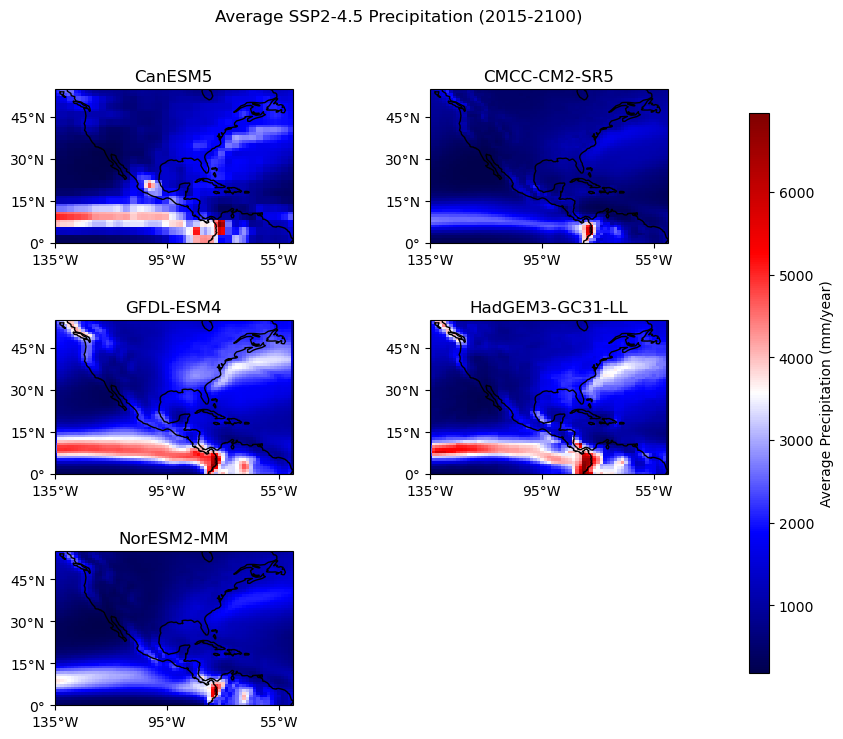

In [14]:
nrows = 3
ncols = 2

models = [can_ssp2, cmcc_ssp2, gfdl_ssp2, had_ssp2, nor_ssp2]
names = ['CanESM5', 'CMCC-CM2-SR5', 'GFDL-ESM4', 'HadGEM3-GC31-LL', 'NorESM2-MM']

# Set up figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

#Loop over all of the models
for i,m in enumerate(models):
    cs = m.plot(ax=axs[i], transform=ccrs.PlateCarree(), cmap='seismic',add_colorbar=False)
    
    # Title each subplot with the name of the model
    axs[i].set_title(names[i])
    
    # Draw the coastines for each subplot
    axs[i].coastlines()

    # Set extent for maps
    axs[i].set_extent([-135, -50, 55, 0], crs=ccrs.PlateCarree())

    #Set Longitude Label
    axs[i].set_xticks(np.arange(-135,-50,40), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].xaxis.label.set_visible(False)

    #Set Latitude Label
    axs[i].set_yticks(np.arange(0,55,15), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].yaxis.label.set_visible(False)

# remove extra subplot
fig.delaxes(axs[5])

# set plot title
plt.suptitle("Average SSP2-4.5 Precipitation (2015-2100)")

#Set colourbar
fig.subplots_adjust(right=0.8, wspace=0.25, hspace=0.5) # plot spacing & placement
cbar_ax = fig.add_axes([0.85,0.15,0.02,0.7]) # placement: [topleft, bottom, width, height]
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', label = 'Average Precipitation (mm/year)')

## Load the SSP5-8.5 Data

In [15]:
can_ssp5 = xr.open_dataset(out_folder / "can_ssp5_regrid.nc")
gfdl_ssp5 = xr.open_dataset(out_folder / "gfdl_ssp5_regrid.nc")
had_ssp5 = xr.open_dataset(out_folder / "had_ssp5_regrid.nc")
nor_ssp5 = xr.open_dataset(out_folder / "nor_ssp5_regrid.nc")

cmcc_ssp5_pr = cmipdf.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'pr' & experiment_id == 'ssp585' & source_id == 'CMCC-CM2-SR5'")


### Select and filter the data

In [16]:
can_ssp5_sel = can_ssp5.sel(member_id='r5i1p2f1', lon = slice(225, 310), lat = slice(0, 55), time = slice('2015', '2100'))
can_ssp5_ds = can_ssp5_sel.drop_vars(['member_id', 'dcpp_init_year'])
can_ssp5_pr = can_ssp5_ds['pr']

gfdl_ssp5_sel = gfdl_ssp5.sel(member_id='r1i1p1f1', lon = slice(225, 310), lat = slice(0, 55), time = slice('2015', '2100'))
gfdl_ssp5_ds = gfdl_ssp5_sel.drop_vars(['member_id', 'dcpp_init_year'])
gfdl_ssp5_pr = gfdl_ssp5_ds['pr']

had_ssp5_sel = had_ssp5.sel(member_id='r4i1p1f3', lon = slice(225, 310), lat = slice(0, 55), time = slice('2015', '2100'))
had_ssp5_ds = had_ssp5_sel.drop_vars(['member_id', 'dcpp_init_year'])
had_ssp5_pr = had_ssp5_ds['pr']

nor_ssp5_sel = nor_ssp5.sel(member_id='r1i1p1f1', lon = slice(225, 310), lat = slice(0, 55), time = slice('2015', '2100'))
nor_ssp5_ds = nor_ssp5_sel.drop_vars(['member_id', 'dcpp_init_year'])
nor_ssp5_pr = nor_ssp5_ds['pr']

cmcc_ssp5_ds = load_data(cmcc_ssp5_pr)
cmcc_ssp5_pr = data_array_ssp(cmcc_ssp5_ds)

gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5/ssp585/r1i1p1f1/Amon/pr/gn/v20200622/


In [17]:
# Unit and Longitude conversion
can_ssp5_lon = convert_lon(can_ssp5_pr)
can_ssp5_pr = convert_precip(can_ssp5_lon)

cmcc_ssp5_lon = convert_lon(cmcc_ssp5_pr)
cmcc_ssp5_pr = convert_precip(cmcc_ssp5_lon)

gfdl_ssp5_lon = convert_lon(gfdl_ssp5_pr)
gfdl_ssp5_pr = convert_precip(gfdl_ssp5_lon)

had_ssp5_lon = convert_lon(had_ssp5_pr)
had_ssp5_pr = convert_precip(had_ssp5_lon)

nor_ssp5_lon = convert_lon(nor_ssp5_pr)
nor_ssp5_pr = convert_precip(nor_ssp5_lon)

In [18]:
# Mean data over time to get average
can_ssp5 = can_ssp5_pr.mean(dim='time')
cmcc_ssp5 = cmcc_ssp5_pr.mean(dim='time')
gfdl_ssp5 = gfdl_ssp5_pr.mean(dim='time')
had_ssp5 = had_ssp5_pr.mean(dim='time')
nor_ssp5 = nor_ssp5_pr.mean(dim='time')

### Plot the SSP5-8.5 Precipitation Data

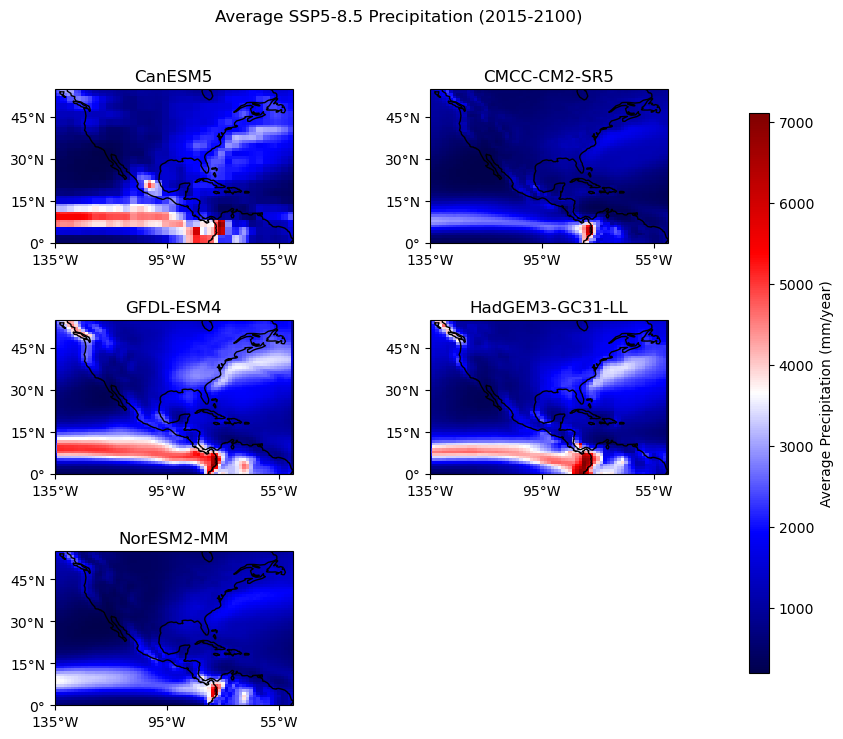

In [19]:
nrows = 3
ncols = 2

models = [can_ssp5, cmcc_ssp5, gfdl_ssp5, had_ssp5, nor_ssp5]
names = ['CanESM5', 'CMCC-CM2-SR5', 'GFDL-ESM4', 'HadGEM3-GC31-LL', 'NorESM2-MM']

# Set up figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

#Loop over all of the models
for i,m in enumerate(models):
    cs = m.plot(ax=axs[i], transform=ccrs.PlateCarree(), cmap='seismic',add_colorbar=False)
    
    # Title each subplot with the name of the model
    axs[i].set_title(names[i])
    
    # Draw the coastines for each subplot
    axs[i].coastlines()

    # Set extent for maps
    axs[i].set_extent([-135, -50, 55, 0], crs=ccrs.PlateCarree())

    #Set Longitude Label
    axs[i].set_xticks(np.arange(-135,-50,40), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].xaxis.label.set_visible(False)

    #Set Latitude Label
    axs[i].set_yticks(np.arange(0,55,15), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].yaxis.label.set_visible(False)

# remove extra subplot
fig.delaxes(axs[5])

# set plot title
plt.suptitle("Average SSP5-8.5 Precipitation (2015-2100)")

#Set colourbar
fig.subplots_adjust(right=0.8, wspace=0.25, hspace=0.5)
cbar_ax = fig.add_axes([0.85,0.15,0.02,0.7])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', label = 'Average Precipitation (mm/year)')